## QUTIP exercise

### Introduction and Imports
In this notebook you will:
- simulate the dynamics of a driven two level system, i.e. a qubit, both in the lab frame and in the qubit frame
- expand the dimension of the Hilbert space to include the a 3rd eigenstate of the transmon qubit, characterizes by the anharmonicity of the 01 and 12 transitions
- implement a gaussian pulse to reduce the effect of leakage
- apply the GRAPE algorithm to find optimal control solutions

In [314]:
#### IMPORTS
%matplotlib inline
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time
import numpy as np
from numpy import pi
from qutip import *
from qutip.qip.operations import *
from qutip.control import *
import qutip.control.pulseoptim as cpo

The system we want to simulate is a single transmon qubit capacitive driven with a microwave signal.
To do so with will use the qutip package (for docs see: https://qutip.org/documentation.html).
Most of the matrix objects you will need are given below.

In [315]:
# PAULI MATRICES
X = sigmax()
Y = sigmay()
Z = sigmaz()
Id = qeye(2)
# UNITARY ROTATIONS BY PI
theta = pi
RXpi = rx(theta) # equivalent of (-1j*theta/2*X).expm()
RYpi = ry(theta)
RZpi = rz(theta)
# USER DEFINED MATRIX
M = Qobj(np.array([[0.+0.j, 0.+0.j],[1.+0.j, 0.+0.j]]))
# USER DEFINED DIAGONAL MATRIX
D = qdiags(np.array([1.+0.j, 0.+1.j]),0)

We also define some plotting functions that we will use throughout the notebook.

In [316]:
def plot_bloch_sphere(me_result, times):
    ## normalize colors to times in tlist ##
    nrm = mpl.colors.Normalize(times[0],times[-1])
    colors = cm.cool(nrm(times))
    ##initialize Bloch sphere
    b = Bloch()
    ## add points of the time dependent state
    b.add_points(me_result.expect[:3],'m')
    ## adding basis states |0> and |1>
    b.add_states(basis(2, 0)) #, 'black') 
    b.add_states(basis(2, 1)) #, 'red')
    ## customize sphere properties and render ##
    b.point_color = list(colors)
    b.point_marker = ['o']
    b.point_size = [10]
    b.zlpos = [1.25,-1.35]
    b.render()
    ## add colorbar
    left, bottom, width, height = [0.98, 0.05, 0.05, 0.9]
    ax2 = b.fig.add_axes([left, bottom, width, height])
    cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cm.cool, norm=nrm, orientation='vertical')
    cbar.set_label('time (s)', rotation=270)
    b.show()

In [317]:
def plot_populations(me_result, times):
    plt.plot(times*1e9, me_result.expect[3], label='0')
    plt.plot(times*1e9, me_result.expect[4], label='1')
    if len(me_result.expect)>5:
        plt.plot(times*1e9, me_result.expect[5], label='2')
    plt.legend()
    plt.xlabel('time (ns)')
    plt.ylabel('population')
    plt.show()

## The system
At first we will approximate the transmon Hamiltonian as having only 2 levels.
Then the qubit is characterized by the energy difference between the two level,
$E_1 - E_0 = \omega_q $ , where we normalize by setting $\hbar=1$.
We will set the eigenfrequency of the qubit to be the realistic value of $\omega_q = 5GHz$.
When writing down the Hamiltonian of this system we will use the optimal control notation:
$H(t) = H_0 + H_c(t) = H_0 + \sum_j c_j(t) H_j$, separating the static part of the Hamiltonian, $H_0$, also known as the drift Hamiltonian, from the time dependent part, in particular identifying separate control Hamiltonians $H_js$.
For the simple case of a single drive we will write $H(t) = H_0 + c(t) H_c$.
Now write down the drift Hamiltonian of the qubit:

In [318]:
omega_q = 5e9 # Hz
H_0 = -(omega_q / 2) * Z
H_0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[-2.5e+09  0.0e+00]
 [ 0.0e+00  2.5e+09]]

To check that the Hamiltonian is correct we can look at it's eigenvalues, i.e. the eigenenergies/eigenfrequency of the system.
Remember, we want that $E_1 - E_0 = \omega_q$.

In [319]:
# find the energy eigenvalues  and eigenvectors of the drift Hamiltonian
evals, ekets = H_0.eigenstates()
print("Eigenvalues")
print(f"{evals}")
print(f"Energy difference: {evals[1] - evals[0]:.2e}")
print("Eigenvalues:")
display(ekets[0])
display(ekets[1])

Eigenvalues
[-2.5e+09  2.5e+09]
Energy difference: 5.00e+09
Eigenvalues:


Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-1.]
 [ 0.]]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

A drive line is capacitively coupled to the qubit so that we can induce rotations about the x axis.
Write down the control hamiltonian

In [320]:
H_c =  X 
H_c

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]

## Control task: Bit flip

Given the control and drift Hamiltonians defined above we want to define a control field $c_t$ that would generate a bit flip. We set a fixed time, $T=50$ ns,for the state evolution and define $N=5000$ timesteps for the simulation of the dynamics.

In [321]:
T = 50*1e-9 # s
N = 5000 # number of time steps
times = np.linspace(0, T, N) # simulation time steps

In [322]:
Omega = pi/ T # choose Omega so there is a pi rotation by time T
omega_d = omega_q # choose the drive to be resonant
def c_t(t): return np.sin(-omega_d * t) * Omega # define here the time dependent control field, which has an amplitude and frequency

In [323]:
# qutip hamiltonian follows optimal control notation
# H = [H_drift, [H_1, c_1(t)], [H_2, c_2(t)], ..., [H_J, c_J(t)]]
H_t = [
    H_0,
    [H_c, c_t(times)]
]
H_t

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[-2.5e+09  0.0e+00]
  [ 0.0e+00  2.5e+09]],
 [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
  Qobj data =
  [[0. 1.]
   [1. 0.]],
  array([      -0.        , -3140911.47893652, -6273969.17438598, ...,
         62187258.96051243, 61660757.16029065, 60980073.92591131])]]

To check if this is the right drive we initialize a ground state of the qubit $|0>$ and evolve it under our defined hamiltonian. As we do so we measure the expection values of the paulis operators so as to then map the evolving state to a Bloch sphere, and the expectation value of the projection operators so as to have obtain the population values.

In [324]:
psi_0 = basis(2, 0)
proj0 = qdiags(np.array([1.+0.j, 0.+0.j]),0)
proj1 = qdiags(np.array([0.+0.j, 1.+0.j]),0)
e_ops = [X, Y, Z, proj0, proj1]

In [325]:
times

array([0.00000000e+00, 1.00020004e-11, 2.00040008e-11, ...,
       4.99799960e-08, 4.99899980e-08, 5.00000000e-08])

In [326]:
me_result = mesolve(H_t, psi_0, times, [], e_ops)

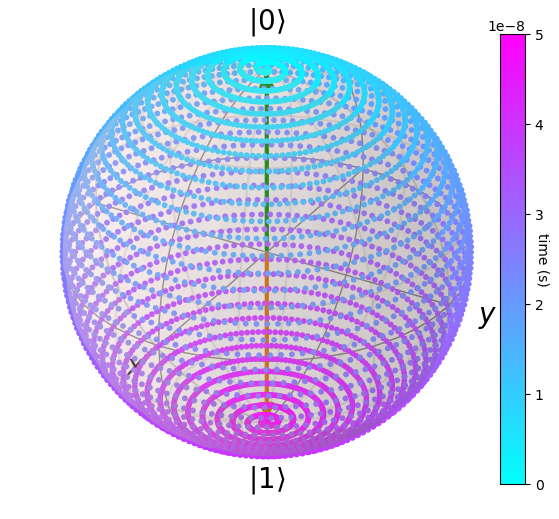

In [327]:
plot_bloch_sphere(me_result, times)

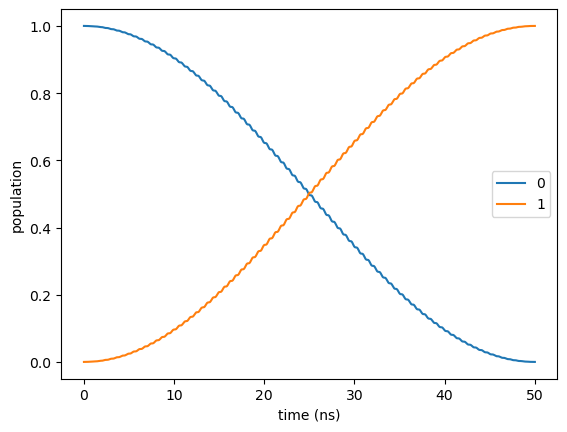

In [328]:
plot_populations(me_result, times)

Above we notice that, although we can flip the states around by correctly driving the resonance frequency, we also see some simultaneous rotations around the $Z$-axis. This is because we are visualizing the qubit in the lab frame, where it is constantly spinning about $Z$-axis. 

## The rotating frame.
Next, we'll move into the frame rotating with the drive by applying the time dependent unitary transformation $U = \exp(-i 
\omega_q Z t)$ to our Hamiltonian and taking the rotating wave approximation, i.e. ignoring terms oscillating at the sum frequency.

In [329]:
H_0 = Z * (omega_q  - omega_d) * 0.5
H_c = X / 2
c_t = np.ones(N) * Omega 
H_t = [
    H_0,
    [H_c, c_t]
]

In [330]:
me_result = mesolve(H_t, psi_0, times, [], e_ops)

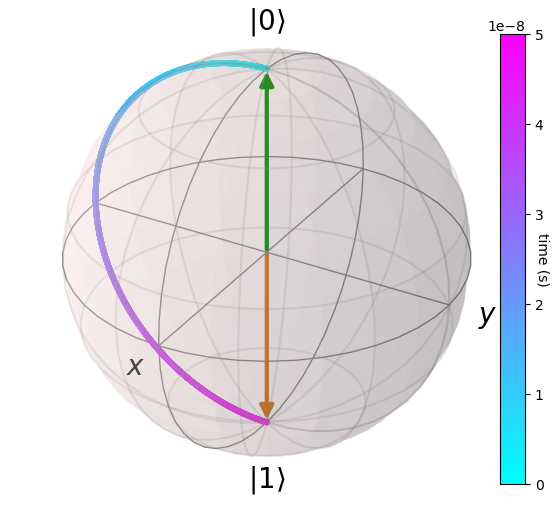

In [331]:
plot_bloch_sphere(me_result, times)

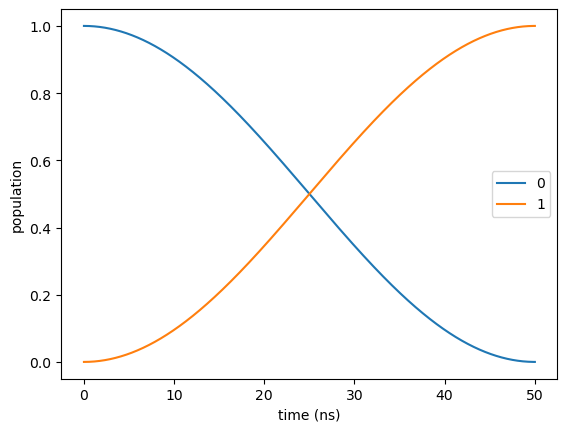

In [332]:
plot_populations(me_result, times)

#### Why did the wiggles we saw in the previous population plot go away? Where did they come from in the first place?

We are also ignoring the fast oscillating terms when doing the RWA

## Transmon: quantum anharmonic oscillator
Until now we have assumed that the transmon qubit has only 2 levels. However, we know that the transmon is a quantum anharmonic oscillator. Hence, we will now include a 3rd level in our simulations and study its effect on the dynamics of the driven system.

We characterize the 3rd level of the transmon by an anharmonicity $\alpha$ defined by difference in the transition energy, $ E_2 - E_1 = E_1 - E_0 + \alpha$. For Transmon qubits the anharmonicity is negative and in the order of $100$ s of MHz.

For our example we set the anharmonicity to $-200$ MHz:


In [333]:
alpha = - 0.2e9# Hz

Now we can write the Hamiltonian of the Transmon using the bosonic annihilation, creation and number operators.
Check again the eigenenergies to ensure that you have correctly defined the Hamiltonian.

In [334]:
## Replace the 0s with the correct values
H_0 = omega_q * num(3) + alpha*0.5* num(3) * (num(3)-qeye(3))    # num() = number operator; qeye() = identity
H_0

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 5.0e+09 0.0e+00]
 [0.0e+00 0.0e+00 9.8e+09]]

Now we run the dynamics again to check what happens when we have a third level. Furthermore, we can measure the occupation in the eigenstates by measuring the projection operations.

In [335]:
H_c = create(3) + destroy(3) # generalized X drive; create() = raising operator ; destroy()  = lowering operator
H_c

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.         1.         0.        ]
 [1.         0.         1.41421356]
 [0.         1.41421356 0.        ]]

In [336]:
## GENERALIZED PAULI AND PROJECTION MATRICES 
## FOR THE 01 AND 12 BLOCH SPHERES (GELL-MANN MATRICES)
sgx01 = Qobj(
    np.array(
        [[0.+0.j, 1.+0.j, 0.0],
         [1.+0.j, 0.+0.j, 0.0],
         [0.+0.j, 0.+0.j, 0.0]]
    )
)
sgy01 = Qobj(
    np.array(
        [[0.+0.j, 0.-1.j, 0.0],
         [0.+1.j, 0.+0.j, 0.0],
         [0.+0.j, 0.+0.j, 0.0]]
    )
)
sgz01 = Qobj(
    np.array(
        [[1.+0.j, 0.+0.j, 0.0],
         [0.+0.j, -1.+0.j, 0.0],
         [0.+0.j, 0.+0.j, 0.0]]
    )
)
sgx12 = Qobj(
    np.array(
        [[0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 1.+0.j,],
         [0.+0.j, 1.+0.j, 0.+0.j]]
    )
)
sgy12 = Qobj(
    np.array(
        [[0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.-1.j],
         [0.+0.j, 0.+1.j, 0.+0.j]]
    )
)
sgz12 = Qobj(
    np.array(
        [[0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, -1.+0.j]]
    )
)
proj0 = qdiags(np.array([1.+0.j, 0.+0.j, 0.+0.j]),0)
proj1 = qdiags(np.array([0.+0.j, 1.+0.j, 0.+0.j]),0)
proj2 = qdiags(np.array([0.+0.j, 0.+0.j, 1.+0.j]),0)
e_ops = [sgx01, sgy01, sgz01, proj0, proj1, proj2, sgx12, sgy12, sgz12]

In [337]:
def c_t(t, *args): # define here the time dependent control field
    return np.sin(-omega_d * t) * Omega 

H_t = [
    H_0,
    [H_c, c_t(times)]
]


psi_0 = psi_0 = basis(3, 0)

# Write up the new H_t  and psi_0 for this 3lvl system
me_result = mesolve(H_t, psi_0, times, [], e_ops)

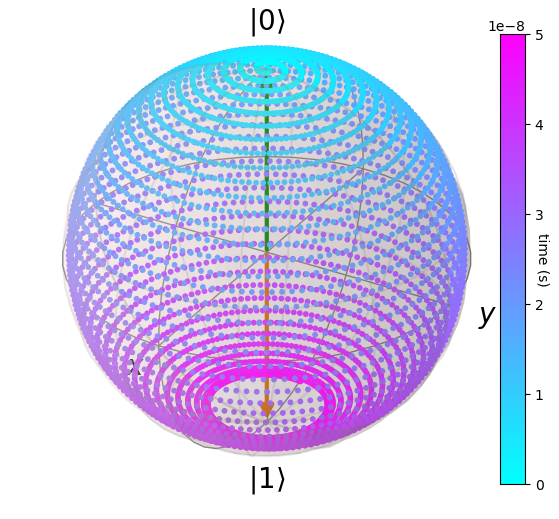

In [338]:
plot_bloch_sphere(me_result, times)

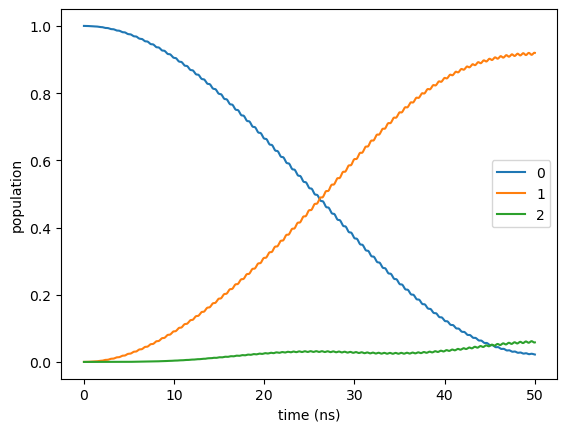

In [339]:
plot_populations(me_result, times)

We straight away see that with a third excited level we don't anymore have the correct dynamics leading to a bit flip. 

Let's again go to the rotating frame to see this effect better. 
To do so we now apply a similar transformation as before but extended to the large space, $U=\exp(-i\omega_d a a^\dagger t)$. We then obtain

In [340]:
## Replace the 0s with the correct values
H_0 = (omega_q- omega_d) * num(3) + alpha*0.5* num(3) * (num(3)-qeye(3))    # num() = number operator; qeye() = identity
#H_0 = 0 * num(3) + 0 * num(3) * (num(3)-qeye(3))
H_c = (create(3) + destroy(3)) / 2
c_t = np.ones(N) * np.pi / T
H_t = [
    H_0,
    [H_c, c_t]
]
print(H_t)
me_result = mesolve(H_t, psi_0, times, [], e_ops)
print(omega_d, omega_q)

[Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00 -2.e+08]], [Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.         0.5        0.        ]
 [0.5        0.         0.70710678]
 [0.         0.70710678 0.        ]], array([62831853.07179586, 62831853.07179586, 62831853.07179586, ...,
       62831853.07179586, 62831853.07179586, 62831853.07179586])]]
5000000000.0 5000000000.0


In [341]:
H_0

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00 -2.e+08]]

In [342]:
H_c

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.         0.5        0.        ]
 [0.5        0.         0.70710678]
 [0.         0.70710678 0.        ]]

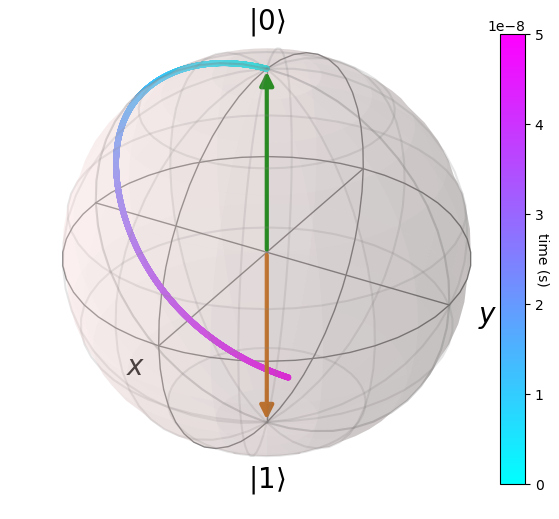

In [343]:
plot_bloch_sphere(me_result, times)

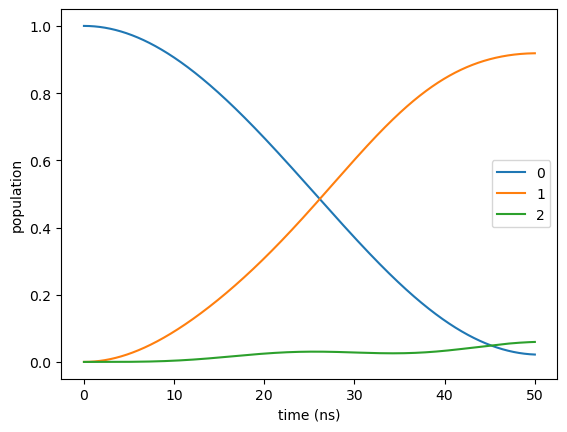

In [344]:
plot_populations(me_result, times)

## Gaussian pulse
Next, let's change the shape of the pulse to reduce it's footprint in frequency space. The gaussian envelope satisfies exactly this property.

In [345]:
import scipy.special
from scipy.integrate import simpson
def gaussian_shape(times):
    '''
    Write this function so that is generates a guassian pulse shape
    with a sigma of T/4 and the centered at T/2.
    Normalize the function so that the area under the pulse is 1,
    i.e. the integral from 0 to T is 1.
    '''     
    sigma = T/4
    cen = T/2
    gaussian = np.exp(-(times - cen)**2 / (2 * sigma**2)) 
    
    # Normalize the pulse
    area_under_pulse = simpson(gaussian, times)
    normalized_pulse = gaussian / area_under_pulse
    #print(simpson(normalized_pulse,times))

    return normalized_pulse

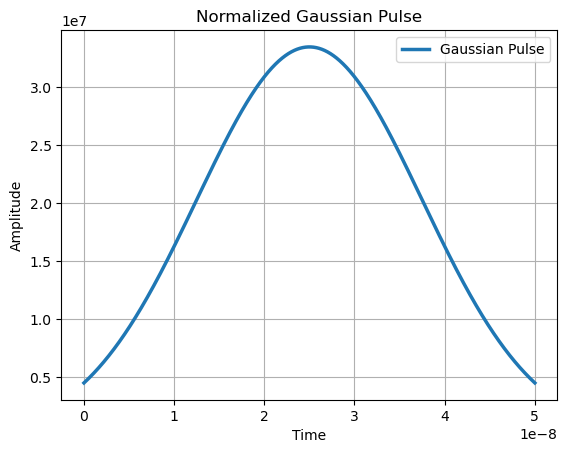

1.0000000000000002


In [346]:
pulse = gaussian_shape(times)

# Plot the pulse
plt.plot(times, pulse, label='Gaussian Pulse', linewidth=2.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Normalized Gaussian Pulse')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
print(simpson(pulse, times))

In [347]:
H_t = [
    H_0,
    [H_c, np.pi * gaussian_shape(times)]
]
me_result = mesolve(H_t, psi_0, times, [], e_ops)


In [348]:
1 - me_result.expect[4][-1]

0.05456198430648007

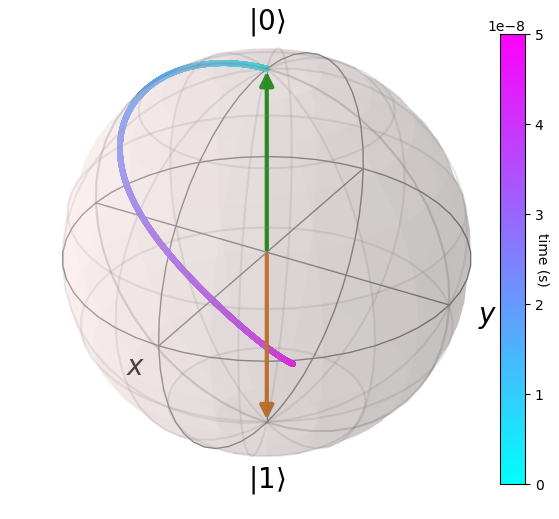

In [349]:
plot_bloch_sphere(me_result, times)

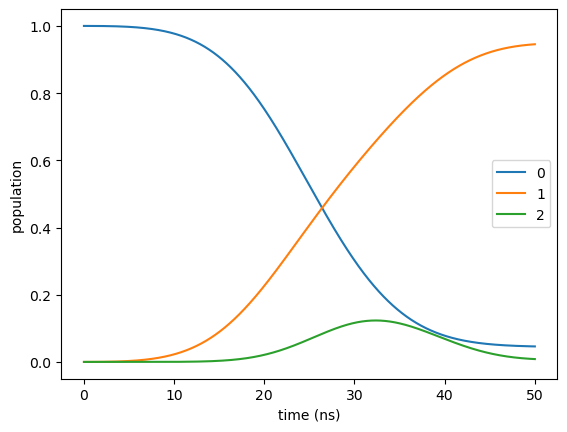

In [350]:
plot_populations(me_result, times)

## GRAPE OPTIMAL CONTROL

We can go further and introduce a quadrature component to the drive.
$c(t)=\Omega_I(t) \cos(\omega_d t) \ \ \longrightarrow c(t)=\Omega_I(t) \cos(\omega_d t) + \Omega_Q(t) \sin(\omega_d t)$.
When going to the rotating frame the $\sin$ drive term becomes a generalized $\sigma_y$ drive in the qubit frame. 

Now to find the optimal shapes for our control variable we use the GRAPE algorithm.

In [351]:
H_0 = H_0 # Our Drift Hamiltonian
H_x = create(3) + destroy(3) # generalized X
H_y = 1j * (create(3) - destroy(3)) # generalized Y
H_ops = [H_x, H_y] # The control Hamiltonians

As the GRAPE algorithm adjusts every pulse step in each of the controls we reduce the number of steps to a minimum to make the algorith faster.

In [352]:
N = 20# number of time steps
times = np.linspace(0, T, N) # simulation time steps

We now need to define the ideal gate we wish to perform:

In [353]:
# enter values in the upper left 2x2 part of the array to target a bit flip operation
U_targ =  Qobj(np.array(
        [[0.+0.j, 1.+0.j, 0.+0.j],
         [1.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j]]
    )
)
U_targ
# the zeros in the third row and coloumn are to ignore the phase of the 2nd excited state

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]

We create the solver object with some specific hyperparameters.

In [354]:
# Fidelity error target
fid_err_targ = 1e-9
# Maximum iterations for the optisation algorithm
max_iter = 20000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-10
# Initial gate
U_0 = identity(3)

optim = cpo.create_pulse_optimizer(H_0, H_ops, U_0, U_targ, N, T,  
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                method_params={'max_metric_corr':20, 'accuracy_factor':1e8},
                dyn_type='UNIT',
                alg ='GRAPE',
                fid_params={'phase_option':'PSU'},
                gen_stats=True)
dyn = optim.dynamics
print(optim)
print(dyn)

Next we define a starting value for the pulse shapes (in the same order as the H_ops). We can give as an initial guess the flat pulse which we used before.

In [355]:
#initital values given as coloumn vectors
init_amps = np.array(
   [pi/2 * gaussian_shape(times), # np.ones(N) * Omega/2,
    np.zeros(N)]
).T 
dyn.initialize_controls(init_amps)

In [356]:
result = optim.run_optimization()

In [357]:
print(result)

Text(0, 0.5, 'singal strength (MHz)')

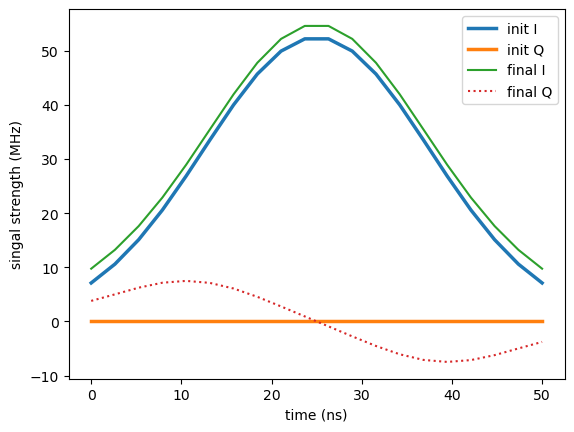

In [358]:
plt.plot(times*1e9, result.initial_amps[:,0]*1e-6,linewidth=2.5, label='init I')
plt.plot(times*1e9, result.initial_amps[:,1]*1e-6, linewidth=2.5, label='init Q')
plt.plot(times*1e9, result.final_amps[:,0]*1e-6, label='final I')
plt.plot(times*1e9, result.final_amps[:,1]*1e-6,linestyle = ':',label='final Q')
plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('singal strength (MHz)')

In [359]:
result.initial_fid_err

0.03360024518203841

In [360]:
result.fid_err

0.0002183835966358405

By applying the optimal control algorithm GRAPE we have been able to reduce the error in our flip operation by almost 3 orders of magnitude, and using only a total of 8 control parameters.

## Anharmonicity and DRAG parameter

The pulse shape described above seems to follow the DRAG prescription:
The DRAG protocol introduce the derivative of the drive envelope on the quadrature component.
$c(t)=\Omega(t) \cos(\omega_d t) \ \ \longrightarrow c(t)=\Omega(t) \cos(\omega_d t) - \delta \dot\Omega(t) \sin(\omega_d t)$, where $\delta$ is the drag parameter.

In [361]:
def gaussian_der(times):
    '''
    Write this function so that is generates the derivative of the guassian pulse
    with a sigma of T/4 and the centered at T/2. Make sure to include the 
    normalization applide to the original pulse.
    ''' 
    cen = T / 2
    sigma = T / 4
    pulse = gaussian_shape(times)
    derivative = -((times - cen) / sigma**2) * pulse
   # midpoint_index = len(times) // 2

    # Create a new array with the first half of elements
    #times_normalisation = times[:midpoint_index]
    #derivative_for_normalisation = derivative[:midpoint_index]
    #area_under_half_pulse = abs(simpson(derivative_for_normalisation, times_normalisation))
    #derivative_normalised= derivative / area_under_half_pulse

    return derivative


    #return derivative_normalised

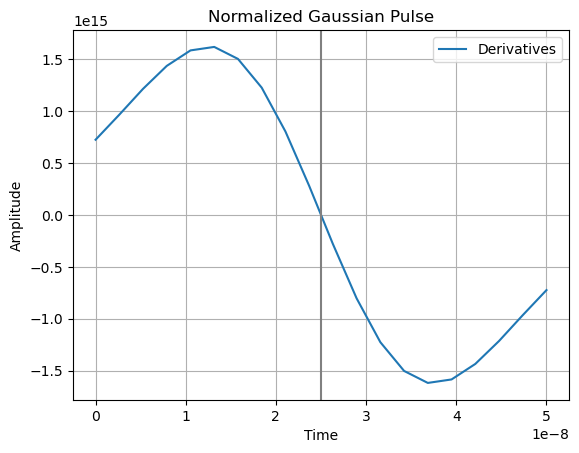

In [362]:
pulse = gaussian_shape(times)
derivative = gaussian_der(times)

# Plot the pulse
#plt.plot(times, pulse, label='Gaussian Pulse')
plt.plot(times,derivative, label = 'Derivatives')
plt.axvline(x= T /2 , color = 'grey')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Normalized Gaussian Pulse')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [363]:
# Fit function to gaussian derivative (i.e drag quadrature component)
from scipy.optimize import curve_fit
def drag(times, drag_par):
    return drag_par * gaussian_der(times)

popt, pcov = curve_fit(drag, times, result.final_amps[:,1])

Text(0, 0.5, 'singal strength (MHz)')

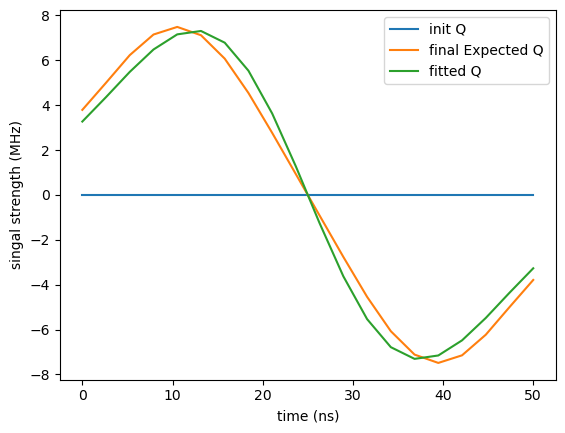

In [364]:
plt.plot(times*1e9, result.initial_amps[:,1]*1e-6, label='init Q')
plt.plot(times*1e9, result.final_amps[:,1]*1e-6, label='final Expected Q')
plt.plot(times*1e9, drag(times, popt[0])*1e-6, label='fitted Q')

plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('singal strength (MHz)')

In [365]:
print(f"fitted value:{popt[0]}")
print(f"expected value:{1/alpha}")

fitted value:4.5179110238323325e-09
expected value:-5e-09


Indeed, we see that althogough only roughly, the shapes seem too match.
To validate this theory perform the same optimal control routine for a range of anharmonicities and fit to the drag parameter. What is the dependence of drag parameter to anharmonicity.
Does the scaling agree with the theoretically expectation?
https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.103.110501

In [378]:
alpha = - 0.2e9# Hz
N_alpha = 100
alpha = np.linspace(-0.25e9,-0.15e9,N_alpha)

In [379]:
N = 20# number of time steps
times = np.linspace(0, T, N) # simulation time steps

In [380]:
H_0 = [(omega_q - omega_d) * num(3) + alpha[i]*0.5* num(3) * (num(3)-qeye(3)) for i in range(N_alpha)]   # num() = number operator; qeye() = identity
H_x = [create(3) + destroy(3) for i in range (N_alpha)]
H_y = [1j * (create(3) - destroy(3)) for i in range (N_alpha)]
H_ops =[ [H_x[i], H_y[i]] for i in range (N_alpha)]

In [381]:
# enter values in the upper left 2x2 part of the array to target a bit flip operation
U_targ =  Qobj(np.array(
        [[0.+0.j, 1.+0.j, 0.+0.j],
         [1.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j]]
    )
)
U_targ
# the zeros in the third row and coloumn are to ignore the phase of the 2nd excited state

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]

In [382]:
# Fidelity error target
fid_err_targ = 1e-9
# Maximum iterations for the optisation algorithm
max_iter = 20000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-10
# Initial gate
U_0 = identity(3)

optim = [cpo.create_pulse_optimizer(H_0[i], H_ops[i], U_0, U_targ, N, T,  
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                method_params={'max_metric_corr':20, 'accuracy_factor':1e8},
                dyn_type='UNIT',
                alg ='GRAPE',
                fid_params={'phase_option':'PSU'},
                gen_stats=True) for i in range (N_alpha)]
dyn = [optim[i].dynamics for i in range (N_alpha)]

In [383]:
#initital values given as coloumn vectors
init_amps = np.array(
   [pi/2 * gaussian_shape(times), # np.ones(N) * Omega/2,
    np.zeros(N)]
).T 
for i in range (N_alpha):
    dyn[i].initialize_controls(init_amps)

In [384]:
result = [optim[i].run_optimization() for i in range (N_alpha)]
final_amplitudes = [result[i].final_amps[:,1] for i in range (N_alpha)]


Text(0, 0.5, 'singal strength (MHz)')

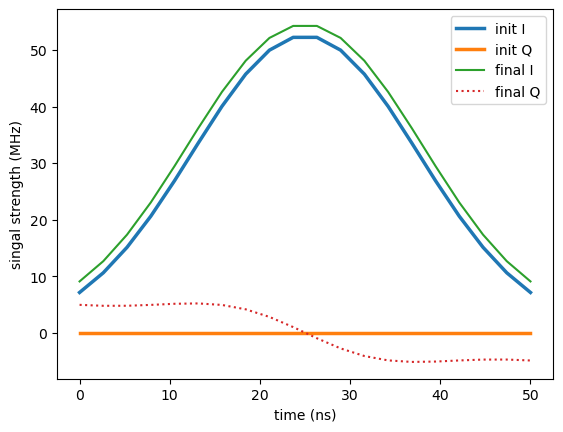

In [385]:
plt.plot(times*1e9, result[0].initial_amps[:,0]*1e-6,linewidth=2.5, label='init I')
plt.plot(times*1e9, result[0].initial_amps[:,1]*1e-6, linewidth=2.5, label='init Q')
plt.plot(times*1e9, result[0].final_amps[:,0]*1e-6, label='final I')
plt.plot(times*1e9, result[0].final_amps[:,1]*1e-6,linestyle = ':',label='final Q')
plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('singal strength (MHz)')

In [386]:
from scipy.optimize import curve_fit
popt_pianto = np.zeros(N_alpha)
for i in range(N_alpha):
    popt, pcov = curve_fit(drag, times, final_amplitudes[i]) 
    popt_pianto[i] = popt[0]

Text(0, 0.5, 'singal strength (MHz)')

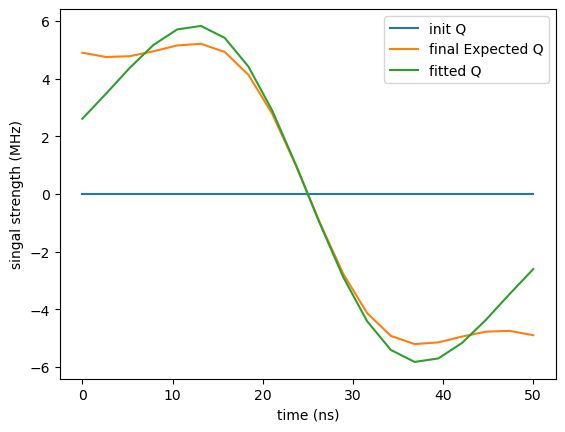

In [387]:
plt.plot(times*1e9, result[1].initial_amps[:,1]*1e-6, label='init Q')
plt.plot(times*1e9, result[1].final_amps[:,1]*1e-6, label='final Expected Q')
plt.plot(times*1e9, drag(times, popt_pianto[1])*1e-6, label='fitted Q')

plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('singal strength (MHz)')

In [388]:
print(f"fitted value:{popt_pianto[1]}")
print(f"expected value:{1/alpha[1]}")

fitted value:3.601943985622757e-09
expected value:-4.016227180527383e-09


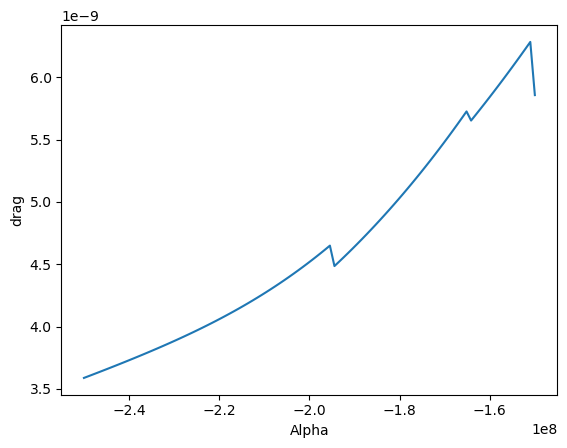

In [389]:
plt.plot(alpha, popt_pianto)
plt.xlabel('Alpha')
plt.ylabel('drag')
plt.show()